# RNN with the use of multiple previous data points

This was an attempt to predict the next data points by using a fixed history of previous points. In the end it wasn't possible to explore this approach in depth, but it would have been the next logical step after the creation of the prediction model, that won the competition. 

## The following cell will mostly contain preparatory steps

### Load all the necessary packages!

In [21]:
import pandas as pd
import seaborn as sns
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import dask.dataframe as dd
from bokeh.io import output_notebook
output_notebook()
from bokeh.models import ColumnDataSource, Span
from bokeh.plotting import figure, show, output_file
import math
from pandas import datetime
from sklearn.metrics import mean_squared_error
from math import sqrt
from matplotlib import pyplot
from keras.models import Sequential
from keras.layers.recurrent import LSTM
from keras.layers.core import Dense, Activation, Dropout
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.utils import shuffle

Loading BokehJS ...

### All the helper functions

In [22]:
# FIXME: This helper function should be rewritten using numpy's shift function. See below.
def create_dataset(dataset, window_size = 1):
    data_X, data_Y = [], []
    for i in range(len(dataset) - window_size - 1):
        a = dataset[i:(i + window_size), 0]
        data_X.append(a)
        data_Y.append(dataset[i + window_size, 0])
    return(np.array(data_X), np.array(data_Y))

### Load data into memory

In [23]:
customers = pd.read_csv('./data/customer_details.csv')
deliveries = pd.read_csv('./data/deliveries.csv')
colocations = pd.read_csv('./data/colocations.csv')
dataset_original = pd.read_csv('./data/level_readings.csv')

### Data Preparation: One hot encode categorical data

Decide which columns should be one hot encoded and which shouldn't. Afterwards use the built in pandas function.

**This step isn't really necessary, because we used the INST_PRODUCT_AMOUNT only.**

In [24]:
include = ['CNTRY_UN_COUNTRY_CODE', 'PROVINCE', 'PRD_ID', 'MKT_SEGMENT']
include_unchanged = ['MAXIMUM_PRODUCT_CAPACITY', 'VESSEL_ID']
one_hot_encoded_customers = pd.get_dummies(customers[include])
one_hot_encoded_customers = pd.concat([one_hot_encoded_customers, customers[include_unchanged]], axis=1)
one_hot_encoded_customers.head()

,CNTRY_UN_COUNTRY_CODE_AU,CNTRY_UN_COUNTRY_CODE_BR,CNTRY_UN_COUNTRY_CODE_CA,CNTRY_UN_COUNTRY_CODE_CN,CNTRY_UN_COUNTRY_CODE_GB,CNTRY_UN_COUNTRY_CODE_IE,CNTRY_UN_COUNTRY_CODE_IN,CNTRY_UN_COUNTRY_CODE_MY,CNTRY_UN_COUNTRY_CODE_NZ,CNTRY_UN_COUNTRY_CODE_TH,...,MKT_SEGMENT_Food & Beverage,MKT_SEGMENT_Food & beverage,MKT_SEGMENT_Healthcare,MKT_SEGMENT_Internal,MKT_SEGMENT_Manufacturing Industries,MKT_SEGMENT_Manufacturing Indutries,MKT_SEGMENT_Metals & Glass,MKT_SEGMENT_internal,MAXIMUM_PRODUCT_CAPACITY,VESSEL_ID
0,0,1,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,2195,BR-216705
1,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,13075,BR-216706
2,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,3567,BR-216721
3,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,13852,BR-216729
4,0,1,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,2195,BR-216732


### Data Preparation: Create a time series data set
Create time series by transforming ON_DATE_TIME strings to datetime objects. 
Further create replace the string column ON_DATE_TIME with a column of type datetime.

**This step isn't really necessary, because we used the INST_PRODUCT_AMOUNT only.**

In [25]:
dataset_original.index = pd.to_datetime(dataset_original.ON_DATE_TIME, format='%Y-%m-%dT%H:%M:%S.%f')
dataset_original.ON_DATE_TIME = pd.to_datetime(dataset_original.ON_DATE_TIME, format='%Y-%m-%dT%H:%M:%S.%f')
dataset_original.head()

,COUNTRY_CODE,INST_ID,INST_PRODUCT_AMOUNT,ON_DATE_TIME,VESSEL_ID
ON_DATE_TIME,,,,,
2017-10-02 00:59:00,MY,62,13870,2017-10-02 00:59:00,MY-62
2017-10-02 01:59:00,MY,62,18330,2017-10-02 01:59:00,MY-62
2017-10-02 02:59:00,MY,62,15367,2017-10-02 02:59:00,MY-62
2017-10-02 03:59:00,MY,62,13805,2017-10-02 03:59:00,MY-62
2017-10-02 04:59:00,MY,62,27870,2017-10-02 04:59:00,MY-62


### Extract all the vessels.

In [26]:
list_of_vessel_ids = deliveries.VESSEL_ID.unique().copy()
list_of_vessel_ids[:4]

array(['UK-3749', 'UK-3806', 'UK-41488', 'UK-63168'], dtype=object)

### Data Preparation: Pick random vessels from the list

Pick training, test and validation vessels to test the model on and check generalisation capabilities.
The training vessel will be used to train a model and check the functionality of the code. The validate vessel will act as a test for the models generalisation capability. The test vessel will act as training data for a larger model, which will also be tested on generalisation capabilities.

In [27]:
copy_of_vessel_ids = list_of_vessel_ids.copy()
# np.random.seed(42)
np.random.shuffle(copy_of_vessel_ids)
copy_of_vessel_ids = copy_of_vessel_ids[1:]
test_id, training_id, validate_id, test_big_model_id = np.random.choice(copy_of_vessel_ids, 4, replace=False)
print(f"Training Vessel: {training_id}")
print(f"Validation Vessel: {validate_id}")
print(f"Test Vessel: {test_id}")
print(f"Test Vessel: {test_big_model_id}")
training_data = dataset_original[dataset_original.VESSEL_ID == training_id]
validate_data = dataset_original[dataset_original.VESSEL_ID == validate_id]
test_data = dataset_original[dataset_original.VESSEL_ID == test_id]
test_big_model_data = dataset_original[dataset_original.VESSEL_ID == test_big_model_id]
training_data.head()

Training Vessel: IN-118590
Validation Vessel: US-313299
Test Vessel: CN-150253
Test Vessel: US-129240


,COUNTRY_CODE,INST_ID,INST_PRODUCT_AMOUNT,ON_DATE_TIME,VESSEL_ID
ON_DATE_TIME,,,,,
2017-08-11 14:59:00,IN,118590,10969,2017-08-11 14:59:00,IN-118590
2017-08-11 15:59:00,IN,118590,10743,2017-08-11 15:59:00,IN-118590
2017-08-11 16:59:00,IN,118590,10453,2017-08-11 16:59:00,IN-118590
2017-08-11 17:59:00,IN,118590,10147,2017-08-11 17:59:00,IN-118590
2017-08-11 18:59:00,IN,118590,9969,2017-08-11 18:59:00,IN-118590


### Create a time series plot.

Just checking out the training data in a time series graph.

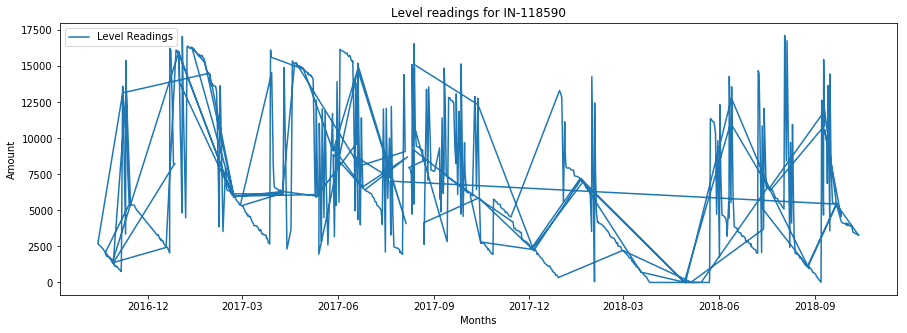

In [28]:
plt.figure(figsize = (15, 5))
plt.plot(training_data.INST_PRODUCT_AMOUNT, label = "Level Readings")
plt.xlabel("Months")
plt.ylabel("Amount")
plt.title(f"Level readings for {training_id}")
plt.legend()
plt.show()

## The following steps will engage in creating the actual predictive model

### Get the raw data values from the pandas data frame

In [29]:
data_raw = training_data.INST_PRODUCT_AMOUNT.values.astype("float32").reshape(-1,1)
data_raw[:5]

array([[10969.],
       [10743.],
       [10453.],
       [10147.],
       [ 9969.]], dtype=float32)

### We apply the MinMax scaler from sklearn to normalize data in the (0, 1) interval.

In [30]:
scaler = MinMaxScaler(feature_range = (0, 1))
dataset = scaler.fit_transform(data_raw)
# Print a few values.
dataset[0:5]

array([[0.6397037 ],
       [0.62652355],
       [0.609611  ],
       [0.5917653 ],
       [0.5813845 ]], dtype=float32)

### Split up the sample vessels training data further for the training.
Use 60% of data for training, 40% for validation.

In [31]:
TRAIN_SIZE = 0.60

train_size = int(len(dataset) * TRAIN_SIZE)
test_size = len(dataset) - train_size
train, test = dataset[0:train_size, :], dataset[train_size:len(dataset), :]
print("Number of entries (training set, test set): " + str((len(train), len(test))))

Number of entries (training set, test set): (1173, 783)


### Create test and training sets for one-step-ahead regression.

In [32]:
window_size = 2
train_X, train_Y = create_dataset(train, window_size)
test_X, test_Y = create_dataset(test, window_size)
print("Original training data shape:")

print("For X:")
print(train_X.shape)
print(train_X[:5])

print("For Y:")
print(train_Y.shape)
print(train_Y[:5])

# Reshape the input data into appropriate form for Keras.
train_X = np.reshape(train_X, (train_X.shape[0], 1, train_X.shape[1]))
test_X = np.reshape(test_X, (test_X.shape[0], 1, test_X.shape[1])) 
print("New training data shape:")
print(train_X.shape)

Original training data shape:
For X:
(1170, 2)
[[0.6397037  0.62652355]
 [0.62652355 0.609611  ]
 [0.609611   0.5917653 ]
 [0.5917653  0.5813845 ]
 [0.5813845  0.56727123]]
For Y:
(1170,)
[0.609611   0.5917653  0.5813845  0.56727123 0.55035865]
New training data shape:
(1170, 1, 2)


### Function for the model training and sample run. To check if the function works.

In [33]:
window_size = 2
def fit_model(train_X, train_Y, window_size = 1, epochs = 2):
    model = Sequential()
    
    model.add(LSTM(4, input_shape = (1, window_size)))
    model.add(Dense(1))
    model.compile(loss = "mean_squared_error", optimizer = "adam")
    model.fit(train_X, 
              train_Y, 
              epochs = epochs, 
              batch_size = 1, 
              verbose = 1)
    
    return(model)

# Fit the first model.
model1 = fit_model(train_X, train_Y, window_size)
model1.summary()

Epoch 1/2
1170/1170 [==============================] - 5s 4ms/step - loss: 0.0598
Epoch 2/2
1170/1170 [==============================] - 4s 3ms/step - loss: 0.0162
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_6 (LSTM)                (None, 4)                 112       
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 5         
Total params: 117
Trainable params: 117
Non-trainable params: 0
_________________________________________________________________


Prediction and scoring function and execution to check if the function works.

In [34]:
def predict_and_score(model, X, Y):
    # Make predictions on the original scale of the data.
    pred = scaler.inverse_transform(model.predict(X))
    # Prepare Y data to also be on the original scale for interpretability.
    orig_data = scaler.inverse_transform([Y])
    # Calculate RMSE.
    score = math.sqrt(mean_squared_error(orig_data[0], pred[:, 0]))
    return(score, pred)

rmse_train, train_predict = predict_and_score(model1, train_X, train_Y)
rmse_test, test_predict = predict_and_score(model1, test_X, test_Y)

print("Training data score: %.2f RMSE" % rmse_train)
print("Test data score: %.2f RMSE" % rmse_test)

Training data score: 2076.65 RMSE
Test data score: 2690.03 RMSE


Plot the results. This plot only uses every 25th data point to reduce the density of the graph.

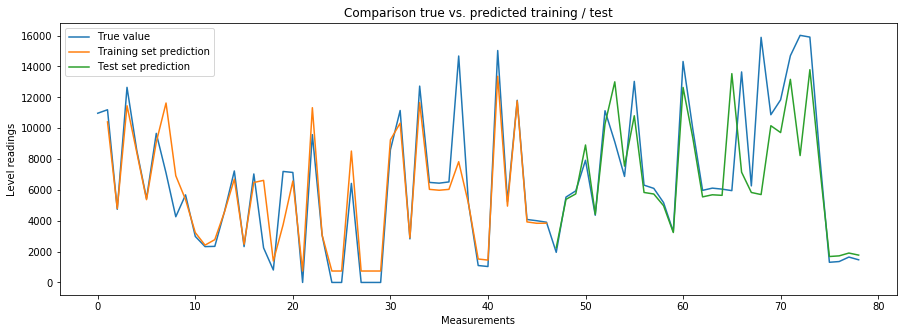

In [35]:
# Start with training predictions.
train_predict_plot = np.empty_like(dataset)
train_predict_plot[:, :] = np.nan
train_predict_plot[window_size:len(train_predict) + window_size, :] = train_predict

# Add test predictions.
test_predict_plot = np.empty_like(dataset)
test_predict_plot[:, :] = np.nan
test_predict_plot[len(train_predict) + (window_size * 2) + 1:len(dataset) - 1, :] = test_predict

# Create the plot.
plt.figure(figsize = (15, 5))
plt.plot(scaler.inverse_transform(dataset[::25]), label = "True value")
plt.plot(train_predict_plot[::25], label = "Training set prediction")
plt.plot(test_predict_plot[::25], label = "Test set prediction")
plt.xlabel("Measurements")
plt.ylabel("Level readings")
plt.title("Comparison true vs. predicted training / test")
plt.legend()
plt.show()

### Test the generalisation capabilities of the model on another vessel. This code copies the previous steps without retraining.

(10701, 1)
Number of entries (Test set):  10701
For X:
(10698, 2)
[[0.5817476  0.57980585]
 [0.57980585 0.57592237]
 [0.57592237 0.57359225]
 [0.57359225 0.56970876]
 [0.56970876 0.56970876]]
For Y:
(10698,)
[0.57592237 0.57359225 0.56970876 0.56970876 0.56970876]
Training data score: 2076.65 RMSE
Test data score: 183.54 RMSE


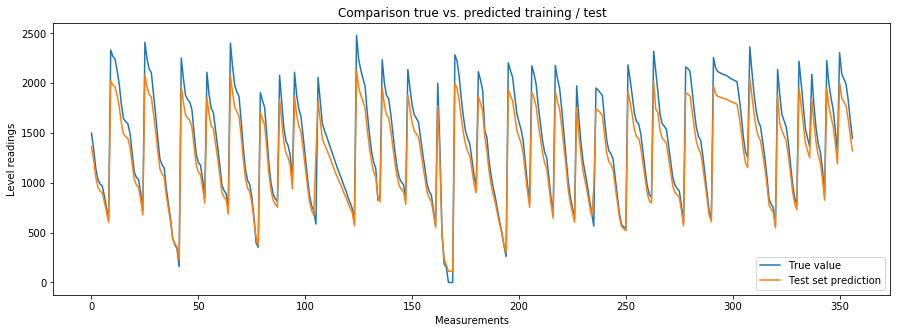

In [36]:
data_raw = validate_data.INST_PRODUCT_AMOUNT.values.astype("float32").reshape(-1,1)
print(data_raw.shape)

scaler = MinMaxScaler(feature_range = (0, 1))
dataset = scaler.fit_transform(data_raw)

test = dataset
print("Number of entries (Test set): ", len(test))

# Create test and training sets for one-step-ahead regression.
window_size = 2
test_X, test_Y = create_dataset(test, window_size)

print("For X:")
print(test_X.shape)
print(test_X[:5])

print("For Y:")
print(test_Y.shape)
print(test_Y[:5])

test_X = np.reshape(test_X, (test_X.shape[0], 1, test_X.shape[1]))

rmse_test, test_predict = predict_and_score(model1, test_X, test_Y)
print("Training data score: %.2f RMSE" % rmse_train)
print("Test data score: %.2f RMSE" % rmse_test)

# Add test predictions.
test_predict_plot = test_predict

# Create the plot.
plt.figure(figsize = (15, 5))
plt.plot(scaler.inverse_transform(dataset[::30]), label = "True value")
plt.plot(test_predict_plot[::30], label = "Test set prediction")
plt.xlabel("Measurements")
plt.ylabel("Level readings")
plt.title("Comparison true vs. predicted training / test")
plt.legend()
plt.show()

### Now that the model above worked, we try again with a bigger window_size and model architecture.

This is a complete repetition of all the steps above in a single cell. Steps include: 
1. Setting up the window size. 
2. Taking the levels of the vessels.
3. Scale down the data
4. Seperate into training and test data
5. Reshaping for model
6. Defining model architecture
7. Training the model
8. Get the RMSE scores and predictions
9. Plotting everything

Shape of input data:
(9304, 1)
Number of entries (training set, test set): (5582, 3722)
Original training data shape:
The shape of training set X is (5531, 50)
The shape of training set Y is (5531,)
A glipse into the data
Y: [0.7332722 0.7332722 0.7332722 0.7332722 0.7332722]
Here are the shapes after reshaping: For training (5531, 1, 50) and for testing (3671, 1, 50)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_7 (LSTM)                (None, 1, 500)            1102000   
_________________________________________________________________
dropout_5 (Dropout)          (None, 1, 500)            0         
_________________________________________________________________
lstm_8 (LSTM)                (None, 500)               2002000   
_________________________________________________________________
dropout_6 (Dropout)          (None, 500)               0         
___________________________________

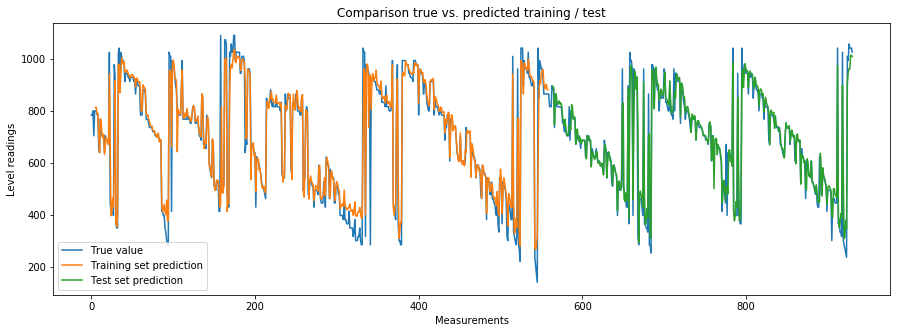

In [37]:
window_size = 50

series = test_data.INST_PRODUCT_AMOUNT.values.astype("float32").reshape(-1,1)

scaler = MinMaxScaler(feature_range = (0, 1))
scaled = scaler.fit_transform(series)

print("Shape of input data:")
print(series.shape)
TRAIN_SIZE = 0.60

train_size = int(TRAIN_SIZE * len(scaled))
test_size = len(scaled) - train_size

train, test = scaled[0:train_size, :], scaled[train_size:len(series), :]
print("Number of entries (training set, test set): " + str((len(train), len(test))))

train_X, train_Y = create_dataset(train, window_size)
test_X, test_Y = create_dataset(test, window_size)

print("Original training data shape:")

print(f"The shape of training set X is {train_X.shape}")
print(f"The shape of training set Y is {train_Y.shape}")

print("A glipse into the data")
# print(f"X: {train_X[:5]}")
print(f"Y: {train_Y[:5]}")

# Reshape the input data into appropriate form for Keras.
train_X = np.reshape(train_X, (train_X.shape[0], 1, train_X.shape[1]))
test_X = np.reshape(test_X, (test_X.shape[0], 1, test_X.shape[1])) 
print(f"Here are the shapes after reshaping: For training {train_X.shape} and for testing {test_X.shape}" )

# Define the model.
model2 = Sequential()
model2.add(LSTM(500, input_shape = (1, window_size), return_sequences=True))
model2.add(Dropout(0.5))
model2.add(LSTM(500))
model2.add(Dropout(0.5))
model2.add(Dense(1))
model2.add(Activation("sigmoid"))
model2.compile(loss = "mse", 
              optimizer = "adam")
model2.summary()

model2.fit(train_X, train_Y, batch_size = 1024, epochs = 20, validation_split = 0.1)
model2.save('./prediction_model_big.h5')

rmse_train, train_predict = predict_and_score(model2, train_X, train_Y)
rmse_test, test_predict = predict_and_score(model2, test_X, test_Y)

print("Training data score: %.2f RMSE" % rmse_train)
print("Test data score: %.2f RMSE" % rmse_test)

# Start with training predictions.
train_predict_plot = np.empty_like(scaled)
train_predict_plot[:, :] = np.nan
train_predict_plot[window_size:len(train_predict) + window_size, :] = train_predict

# Add test predictions.
test_predict_plot = np.empty_like(scaled)
test_predict_plot[:, :] = np.nan
test_predict_plot[len(train_predict) + (window_size * 2) + 1:len(scaled) - 1, :] = test_predict

# Create the plot.
plt.figure(figsize = (15, 5))
plt.plot(scaler.inverse_transform(scaled[::10]), label = "True value")
plt.plot(train_predict_plot[::10], label = "Training set prediction")
plt.plot(test_predict_plot[::10], label = "Test set prediction")
plt.xlabel("Measurements")
plt.ylabel("Level readings")
plt.title("Comparison true vs. predicted training / test")
plt.legend()
plt.show()


### Test the generalisation capabilities of the model on another vessel. This code copies the previous steps without retraining.

This cell shows the generalisation capability of the big model. The model seems to have an understanding of the actual datas basic behaviour, as it folows the up and down spikes. IT isn't good in predicting the actual level of this foreign level as it hasn't been trained on that one.

It would be interesting to know what happens if the model get's multiple vessels to train on.

(10701, 1)
Number of entries (Test set):  9718
For X:
(9667, 50)
For Y:
(9667,)


/glob/intel-python/versions/2018u2/intelpython3/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by MinMaxScaler.
  warnings.warn(msg, DataConversionWarning)


Training data score: 77.84 RMSE
Test data score: 1773.79 RMSE


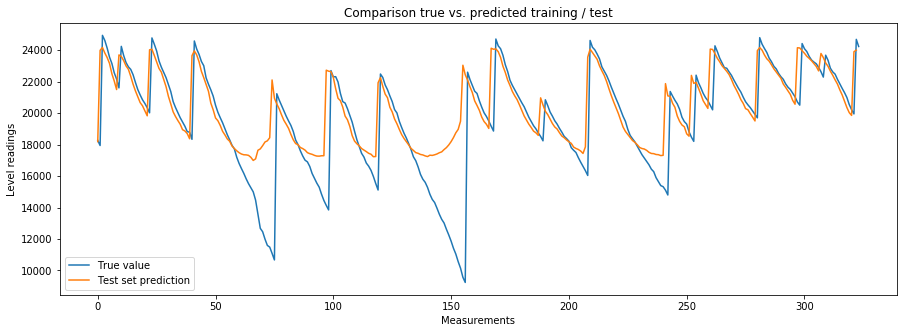

In [38]:
series = test_big_model_data.INST_PRODUCT_AMOUNT.values.reshape(-1,1)
print(data_raw.shape)

scaler = MinMaxScaler(feature_range = (-1, 1))
scaled = scaler.fit_transform(series)

test = scaled
print("Number of entries (Test set): ", len(test))

# Convert to data frame.
test_X, test_Y = create_dataset(scaled, window_size)

print("For X:")
print(test_X.shape)
# print(test_X[:5])

print("For Y:")
print(test_Y.shape)
# print(test_Y[:5])

test_X = np.reshape(test_X, (test_X.shape[0], 1, test_X.shape[1]))

# Predict on test data.
rmse_test, test_predict = predict_and_score(model2, test_X, test_Y)
print("Training data score: %.2f RMSE" % rmse_train)
print("Test data score: %.2f RMSE" % rmse_test)

# Add test predictions.
test_predict_plot = test_predict

# Create the plot.
plt.figure(figsize = (15, 5))
plt.plot(scaler.inverse_transform(scaled[::30]), label = "True value")
plt.plot(test_predict_plot[::30], label = "Test set prediction")
plt.xlabel("Measurements")
plt.ylabel("Level readings")
plt.title("Comparison true vs. predicted training / test")
plt.legend()
plt.show()

### Exploring possible alternatives: Trying to use rolling data inputs.

This didn't work unfortunately and we weren't able to explore it further in the hackathon.

In [39]:
window_size = 4
rolling_prediction_cnt = 3
series = dataset_original[dataset_original.VESSEL_ID == "UK-22643"].INST_PRODUCT_AMOUNT.values.astype("float32").reshape(-1,1)

scaler = MinMaxScaler(feature_range = (0, 1))
scaled = scaler.fit_transform(series)

print("Shape of input data:")
print(series.shape)
TRAIN_SIZE = 0.60

train_size = int(TRAIN_SIZE * len(scaled))
test_size = len(scaled) - train_size

train, test = scaled[0:train_size, :], scaled[train_size:len(scaled), :]
print("Number of entries (training set, test set): " + str((len(train), len(test))))

train_X, train_Y = create_dataset(train, window_size)
test_X, test_Y = create_dataset(test, window_size)

print("Original training data shape:")

print(f"The shape of training set X is {train_X.shape}")
print(f"The shape of training set Y is {train_Y.shape}")

print("A glipse into the data")
# print(f"X: {train_X[:5]}")
# print(f"Y: {train_Y[:5]}")

# Reshape the input data into appropriate form for Keras.
train_X = np.reshape(train_X, (train_X.shape[0], 1, train_X.shape[1]))
test_X = np.reshape(test_X, (test_X.shape[0], 1, test_X.shape[1])) 
print(f"Here are the shapes after reshaping: For training {train_X.shape} and for testing {test_X.shape}" )

# Define the model.
model3 = Sequential()
model3.add(LSTM(50, input_shape = (1, window_size), return_sequences=True))
model3.add(Dropout(0.5))
model3.add(LSTM(50))
model3.add(Dropout(0.5))
model3.add(Dense(1))
model3.add(Activation("sigmoid"))
model3.compile(loss = "mse", 
              optimizer = "adam")
model3.summary()

model3.fit(train_X, train_Y, batch_size = 1024, epochs = 3, validation_split = 0.1, verbose=1)
model3.save('./prediction_model_continuous.h5')

pred_list = []
pred_test = None

print("======================")
temp_train = train
temp_train_X_pre_shaping, temp_train_Y_absolute = create_dataset(temp_train, window_size)
print(f"Shape of initial input: {temp_train.shape}")
# print(f"Training targets shape: {temp_train_Y_absolute[-5:]}")
print(f"Train actuals: {temp_train_Y_absolute[-5:]}")
print(f"Test actuals: {test_Y[:rolling_prediction_cnt]}")
print("======================")
for i in range(rolling_prediction_cnt):
    temp_train_X_pre_shaping, temp_train_Y = create_dataset(temp_train, window_size)
    temp_train_X = np.reshape(temp_train_X_pre_shaping, (temp_train_X_pre_shaping.shape[0], 1, temp_train_X_pre_shaping.shape[1]))
#     print(f"Shape of train_X input: {temp_train_X.shape}")
    print(f"Last 5 training instances: {temp_train_X_pre_shaping[-5:]}")
#     
#     print(f"Last 5 training actuals: {temp_train_Y_absolute[-5:]}")
    pred_test = model3.predict(temp_train_X)
#     print(f"Prediction result shape: {pred_test.shape}")
    print(f"Last 5 predictions: {pred_test.flatten()[-5:]}")
    pred_test_actual = scaler.inverse_transform(pred_test.reshape(pred_test.shape[0], 1))
    temp_train = np.append(temp_train,pred_test[-1])
    print(f"Last 5 of appended training data: {temp_train[-5:]}")
    temp_train = temp_train[1:]
    temp_train = temp_train.reshape(temp_train.shape[0], 1)
#     print(f"Prediction of newly created: {temp_train.shape}")
    pred_list.append(pred_test_actual[-1])
    print("======================")




Shape of input data:
(23094, 1)
Number of entries (training set, test set): (13856, 9238)
Original training data shape:
The shape of training set X is (13851, 4)
The shape of training set Y is (13851,)
A glipse into the data
Here are the shapes after reshaping: For training (13851, 1, 4) and for testing (9233, 1, 4)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_9 (LSTM)                (None, 1, 50)             11000     
_________________________________________________________________
dropout_7 (Dropout)          (None, 1, 50)             0         
_________________________________________________________________
lstm_10 (LSTM)               (None, 50)                20200     
_________________________________________________________________
dropout_8 (Dropout)          (None, 50)                0         
_________________________________________________________________
dense_6 (Dense)       

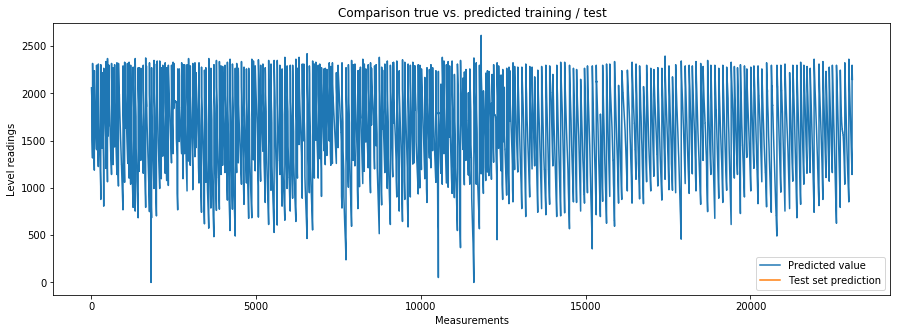

In [40]:
# Start with training predictions.
# train_predict_plot = np.empty_like(scaled)
# train_predict_plot[:, :] = np.nan
# train_predict_plot[window_size:len(train_predict) + window_size, :] = train_predict    
    
# # Add test predictions.
test_predict_plot = np.empty_like(scaled)
test_predict_plot[:, :] = np.nan
test_predict_plot[len(train_Y) + (window_size * 2) + 1:len(scaled) - 1, :] = scaler.inverse_transform(test_Y.reshape(test_Y.shape[0],1) )
    
plt.figure(figsize = (15, 5))
plt.plot(scaler.inverse_transform(scaled[:]), label="Predicted value")
plt.plot(test_predict_plot[:rolling_prediction_cnt], label = "Test set prediction")
# plt.plot(scaler.inverse_transform(test_Y.reshape(test_Y.shape[0],1)[:rolling_prediction_cnt]), label = "True value")
# plt.plot(pred_test_actual[-rolling_prediction_cnt:], label="Predicted value")
plt.xlabel("Measurements")
plt.ylabel("Level readings")
plt.title("Comparison true vs. predicted training / test")
plt.legend()
plt.show()